# Heterogenous Agent New Keynesian (HANK) model - with sticky prices

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Step 1: Steady state](#toc2_)    
  - 2.1. [Policy functions](#toc2_1_)    
  - 2.2. [Simulation](#toc2_2_)    
- 3. [Step 2: Compute Jacobians (incl. tests)](#toc3_)    
- 4. [Step 3a: Find non-linear transition path](#toc4_)    
  - 4.1. [Find transition path](#toc4_1_)    
  - 4.2. [Plot transitions](#toc4_2_)    
  - 4.3. [Find effect of parameter change](#toc4_3_)    
- 5. [Step 3b: Find linearized IRFs](#toc5_)    
- 6. [Step 4. Simulation](#toc6_)    
- 7. [Decomposing household behavior](#toc7_)    
- 8. [Representative agent model](#toc8_)    
  - 8.1. [Fiscal spending shock](#toc8_1_)    
- 9. [Extra: Allow for borrowing](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKModel import HANKModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKModelClass(name='baseline')

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 1000

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [w,r,d,tau]
 inputs_hh_z: []
 outputs_hh: [a,c,ell,n]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma,istar,G]
 unknowns: [Y,w,pi]
 targets: [NKPC_res,clearing_N,clearing_A]

blocks (inputs -> outputs):
 production: [Gamma,w,Y] -> [N,s]
 taylor: [istar,pi,Y] -> [i]
 fisher: [i,pi] -> [r]
 government: [G,r] -> [B,tau]
 intermediary_goods: [r,s,Y,pi] -> [NKPC_res,adjcost,d]
 hh: [d,r,tau,w] -> [A_hh,C_hh,ELL_hh,N_hh]
 market_clearing: [B,N,Y,G,adjcost,N_hh,A_hh,C_hh,r,w] -> [A,clearing_N,clearing_A,clearing_Y]


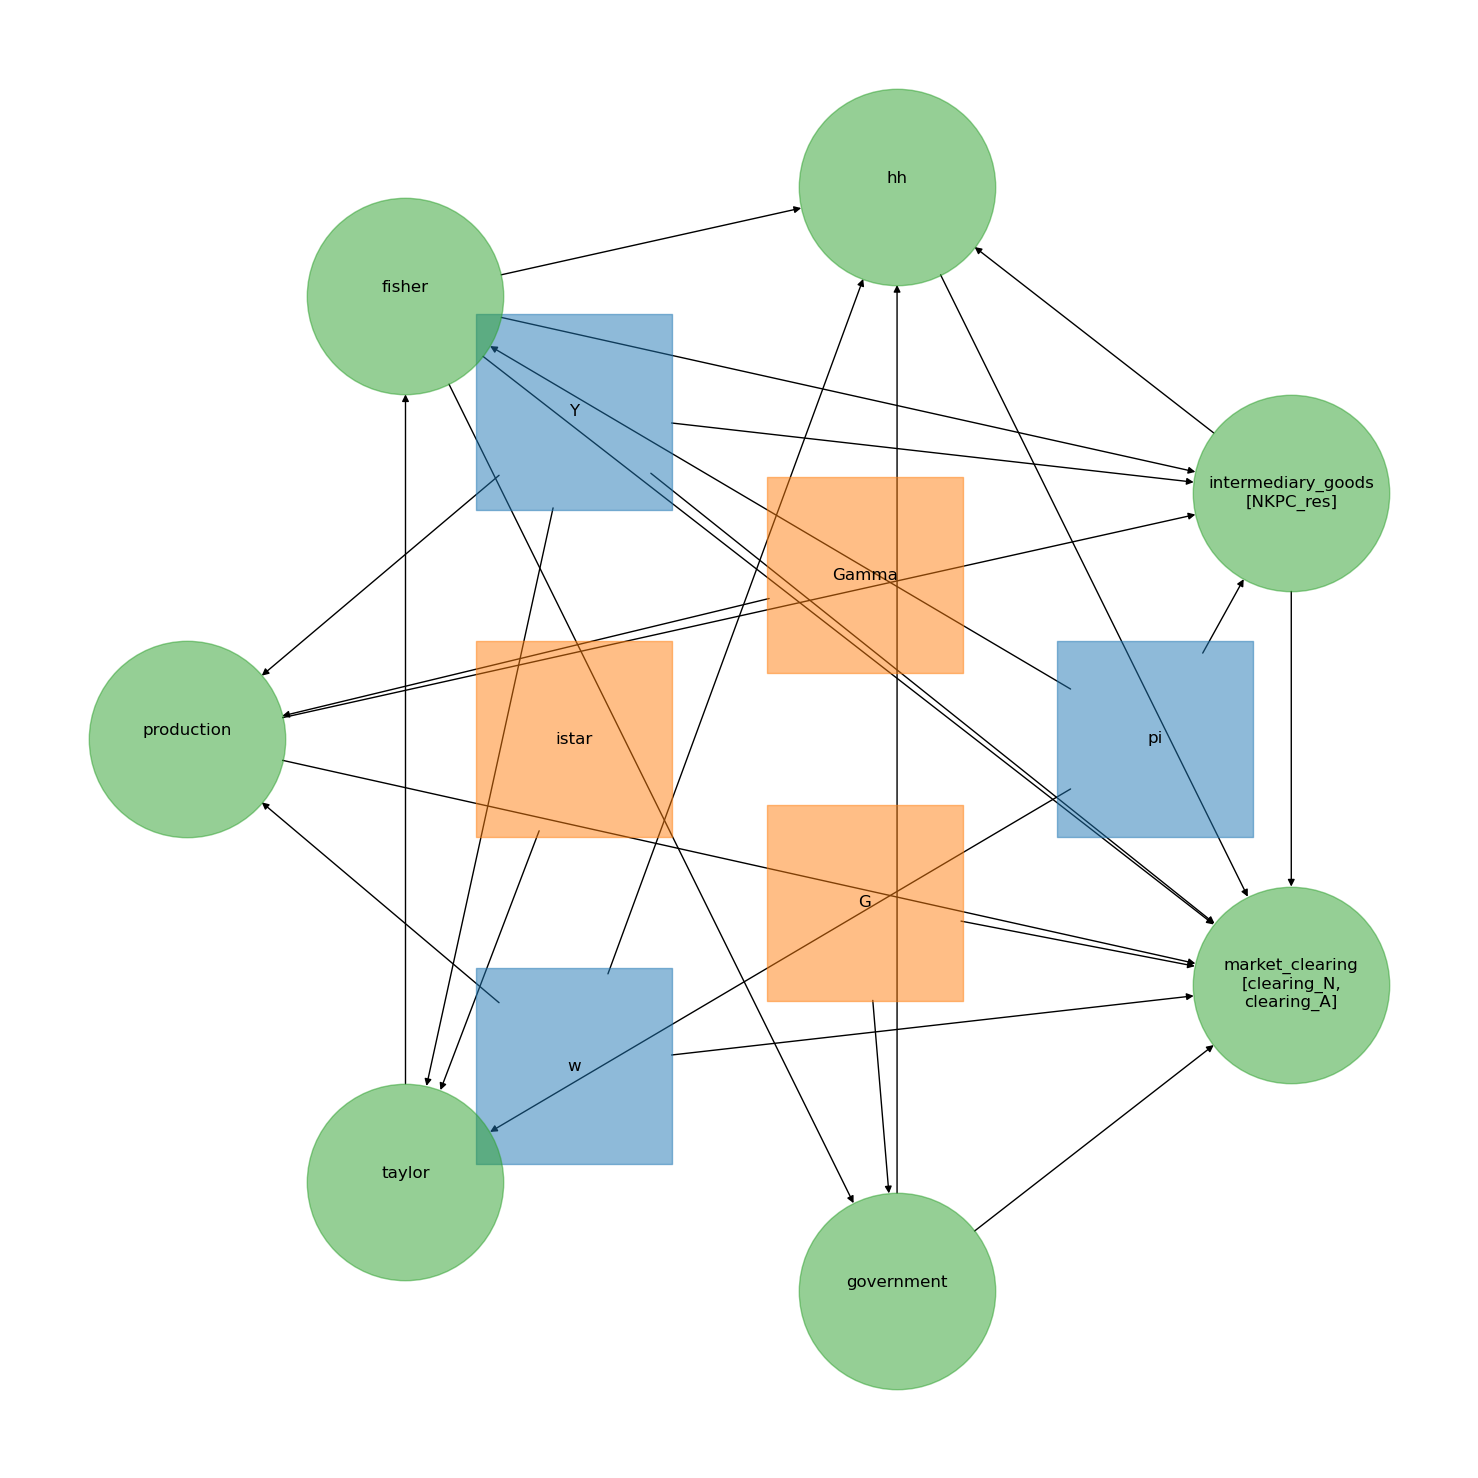

In [4]:
model.draw_DAG(figsize=(15,15),order=['shocks','unknowns','blocks'])

## 2. <a id='toc2_'></a>[Step 1: Steady state](#toc0_)

In [5]:
model.find_ss(do_print=True)

steady state found in 18.4 secs
 beta   =   0.9773
 varphi =   0.7889

Discrepancy in A =   0.00000000
Discrepancy in N =   0.00000000
Discrepancy in Y =   0.00000000


In [6]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

### 2.1. <a id='toc2_1_'></a>[Policy functions](#toc0_)

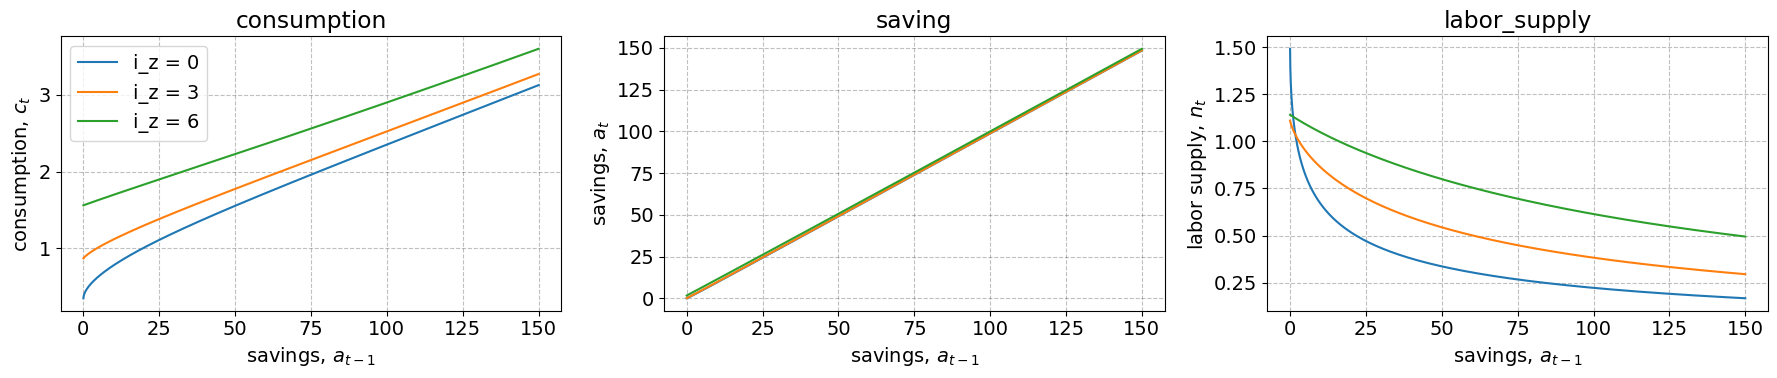

In [7]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

### 2.2. <a id='toc2_2_'></a>[Simulation](#toc0_)

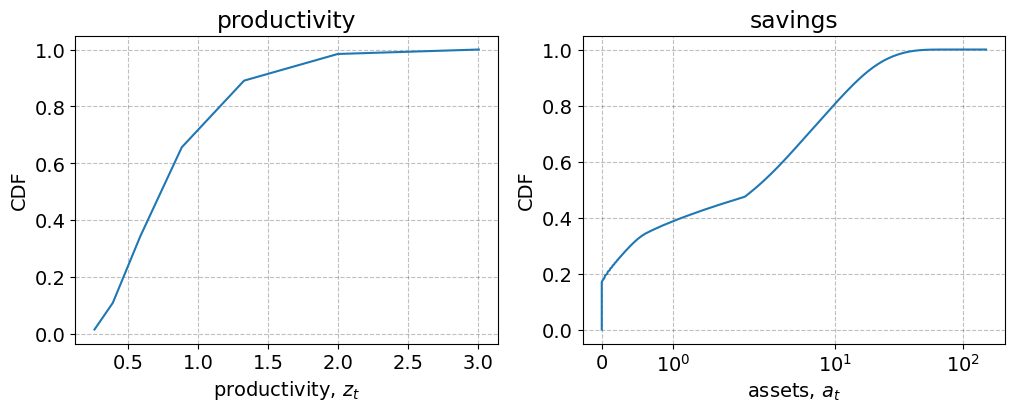

In [8]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


## 3. <a id='toc3_'></a>[Step 2: Compute Jacobians (incl. tests)](#toc0_)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line) in roughly -10^-5 to 10^5

household problem solved along transition path in 1.3 secs
household problem simulated along transition in 1.5 secs



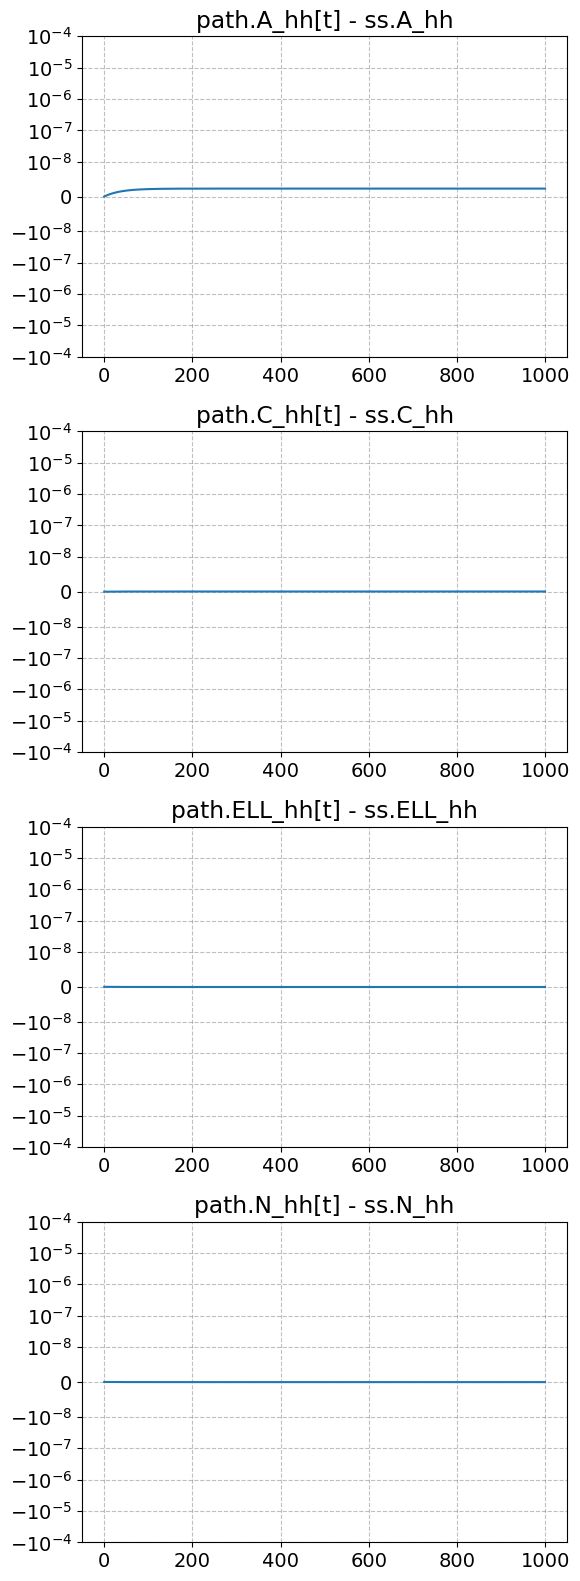

In [9]:
model.test_hh_path()

**Full transition path:**

In [10]:
model.test_path()

shocks: Gamma istar G 
unknowns: Y w pi 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  N                0.0e+00
  s                0.0e+00
 blocks.taylor
  i                0.0e+00
 blocks.fisher
  r                8.7e-18
 blocks.government
  B                0.0e+00
  tau              4.9e-17
 blocks.intermediary_goods
  NKPC_res         0.0e+00 [target]
  adjcost          0.0e+00
  d                0.0e+00
 hh
  A_hh             2.3e-09
  C_hh             5.2e-11
  ELL_hh           5.1e-11
  N_hh             4.2e-11
 blocks.market_clearing
  A                0.0e+00
  clearing_N       4.2e-11 [target]
  clearing_A       2.3e-09 [target]
  clearing_Y       5.2e-11


In [11]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d               in 1.1 secs
curly_Y and curly_D calculated for r               in 1.1 secs
curly_Y and curly_D calculated for tau             in 1.1 secs
curly_Y and curly_D calculated for w               in 1.2 secs
curly_E calculated in 2.3 secs
builiding blocks combined in 1.3 secs
household Jacobian computed in 8.1 secs

full Jacobians:
full Jacobian to unknowns computed in 3.5 secs [in evaluate_blocks(): 2.0 secs]
full Jacobian to shocks computed in 3.4 secs [in evaluate_blocks(): 1.8 secs]


## 4. <a id='toc4_'></a>[Step 3a: Find non-linear transition path](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Find transition path](#toc0_)

In [12]:
model.find_transition_path(shocks=['istar'],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.39e-02
   0.00e+00 in NKPC_res
   2.65e-03 in clearing_N
   1.39e-02 in clearing_A
 it =   1 -> max. abs. error = 1.16e-04
   8.89e-07 in NKPC_res
   9.80e-06 in clearing_N
   1.16e-04 in clearing_A
 it =   2 -> max. abs. error = 5.83e-07
   3.76e-08 in NKPC_res
   5.80e-08 in clearing_N
   5.83e-07 in clearing_A
 it =   3 -> max. abs. error = 1.14e-08
   1.27e-10 in NKPC_res
   1.96e-09 in clearing_N
   1.14e-08 in clearing_A
 it =   4 -> max. abs. error = 1.39e-10
   1.63e-13 in NKPC_res
   2.66e-11 in clearing_N
   1.39e-10 in clearing_A
 it =   5 -> max. abs. error = 3.79e-13
   8.96e-15 in NKPC_res
   8.19e-14 in clearing_N
   3.79e-13 in clearing_A

transition path found in 9.8 secs


### 4.2. <a id='toc4_2_'></a>[Plot transitions](#toc0_)

### shocks ###


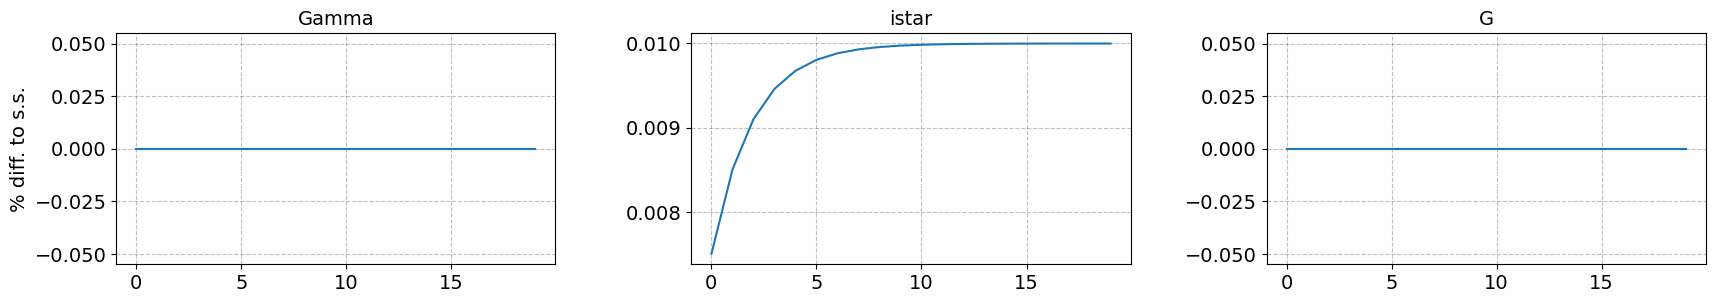


### varnames ###


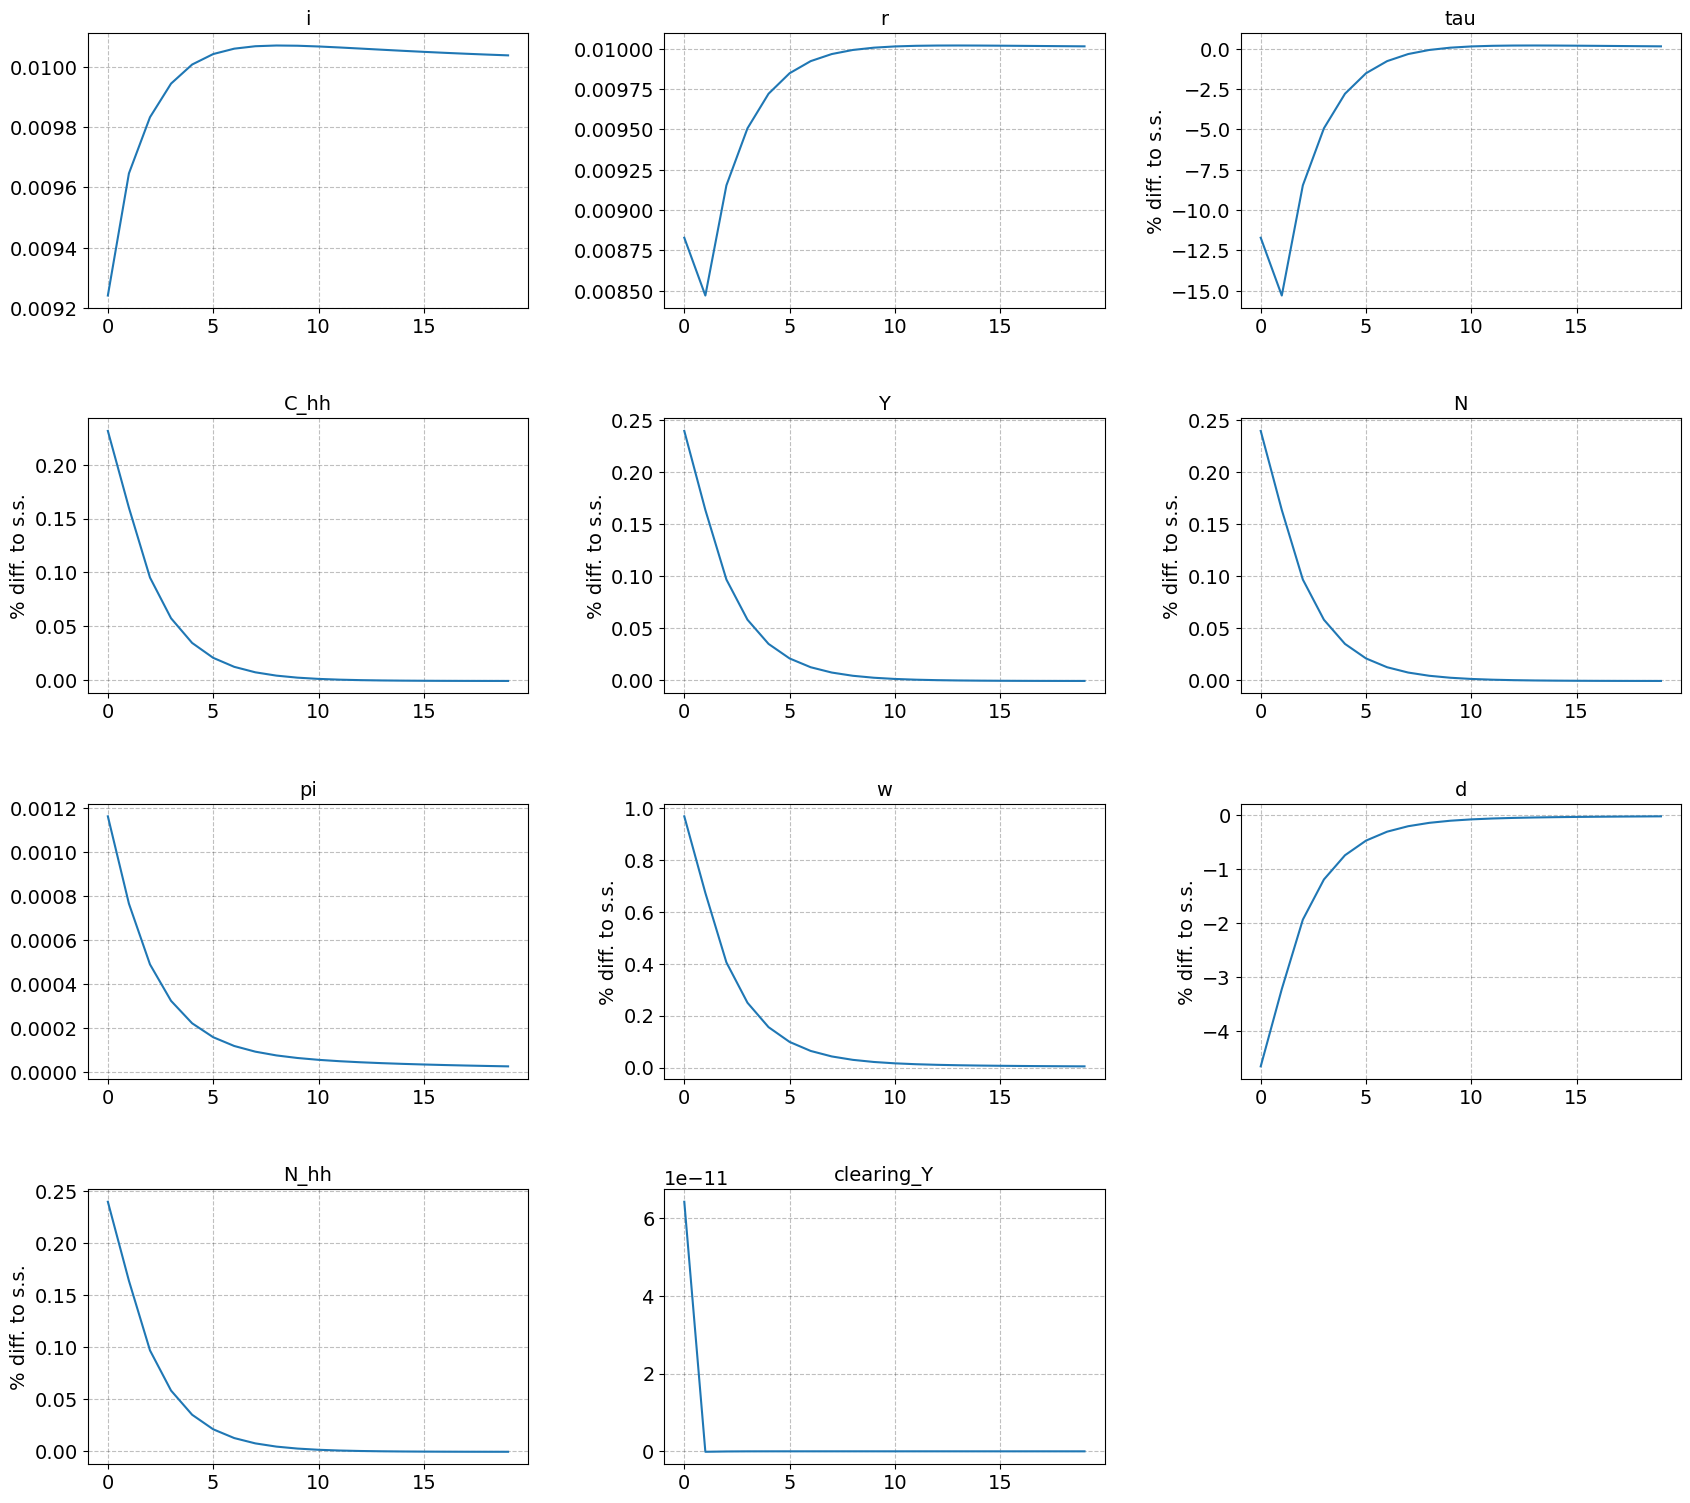


### tagets ###


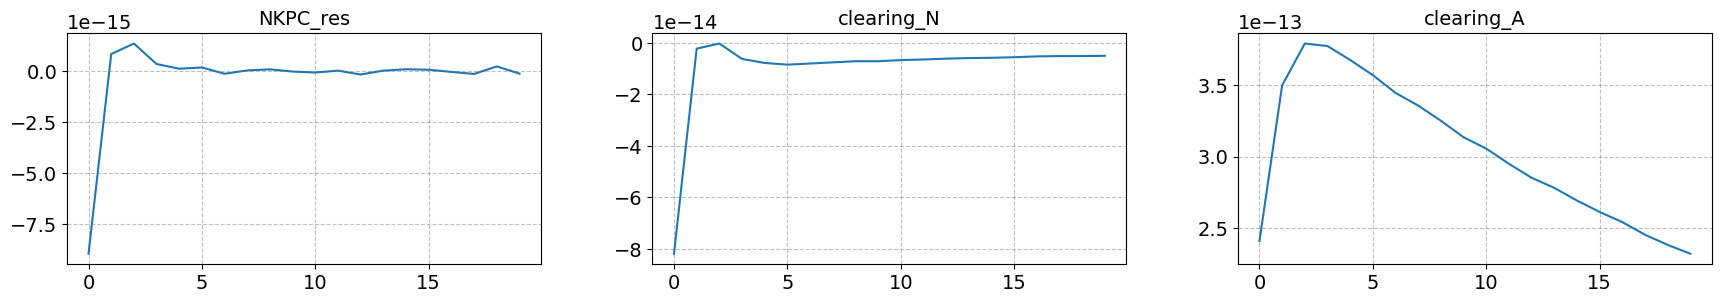

In [13]:
paths = ['i','r','tau','C_hh','Y','N','pi','w','d','N_hh','clearing_Y']
lvl_value = ['i','pi','r','istar','G','clearing_Y']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

### 4.3. <a id='toc4_3_'></a>[Find effect of parameter change](#toc0_)

In [14]:
model_ = model.copy()
model_.par.kappa = 0.0025
model_.compute_jacs(skip_hh=True,skip_shocks=True)
model_.find_transition_path(shocks=['istar'])


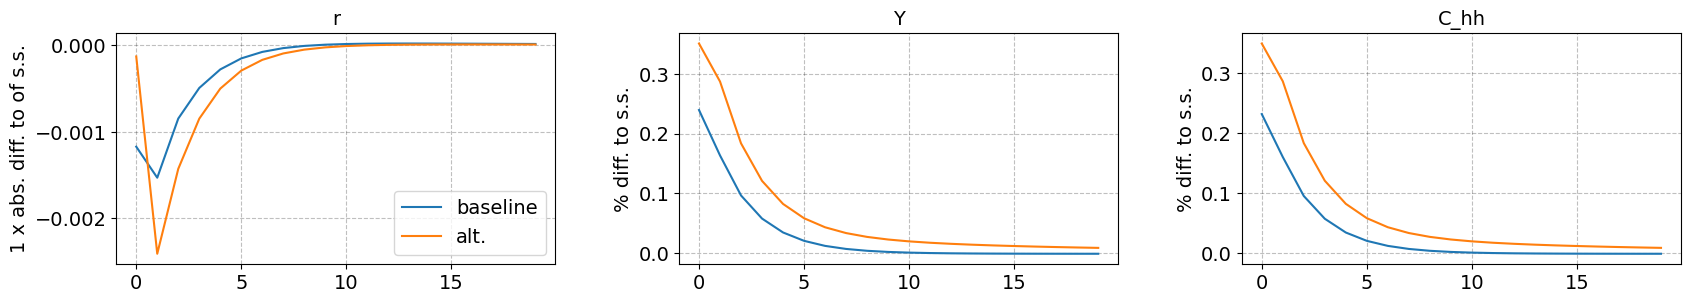

In [15]:
paths = ['r','Y','C_hh']
model.compare_IRFs([model,model_],['baseline','alt.'],
                   paths,lvl_value,do_shocks=False,do_targets=False,ncols=3,T_max=20)

## 5. <a id='toc5_'></a>[Step 3b: Find linearized IRFs](#toc0_)

In [16]:
model.find_IRFs(shocks=['istar'],do_print=True)

linear transition path found in 1.0 secs [finding solution matrix: 0.9 secs]


### shocks ###


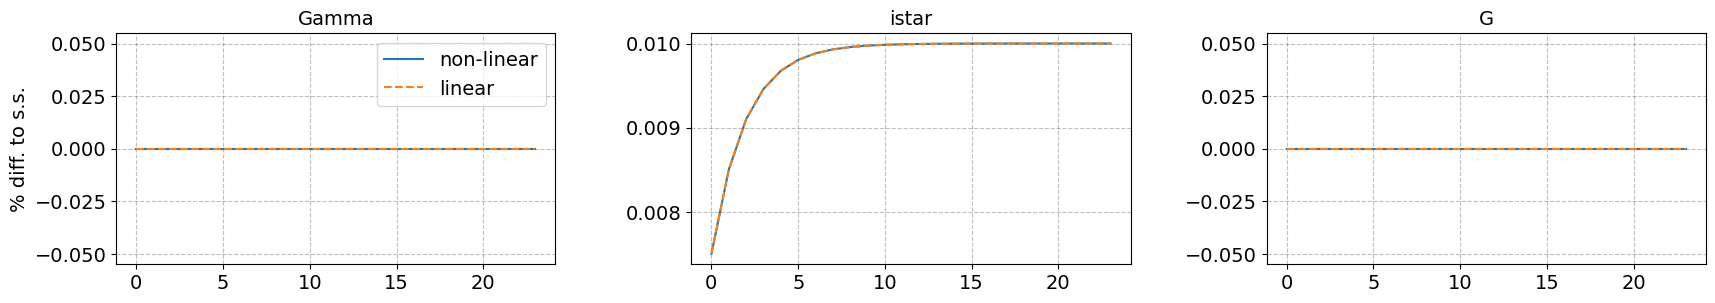


### varnames ###


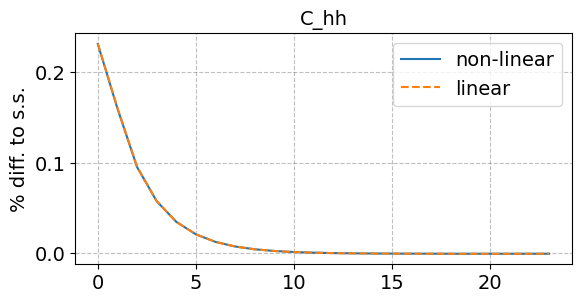


### tagets ###


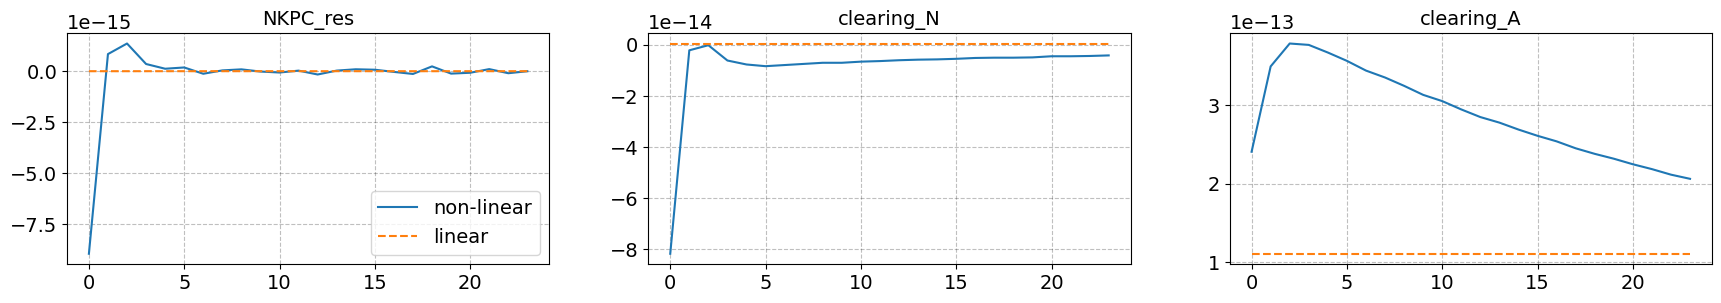

In [17]:
paths = ['C_hh']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=24,ncols=3,do_linear=True)

## 6. <a id='toc6_'></a>[Step 4. Simulation](#toc0_)

In [18]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 1.0 mins 12 secs [solution matrix: 1.0 secs, households: 1.0 mins 11 secs]
aggregates simulated in 0.9 secs
household policies simulated in 21.2 secs
distribution simulated in 0.7 secs
aggregates calculated from distribution in 0.0 secs


In [19]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C_hh')
    ax.plot(ss.C_hh+sim.dC_hh,ls='--',)
    ax.axhline(ss.C_hh,color='black',zorder=0)
    

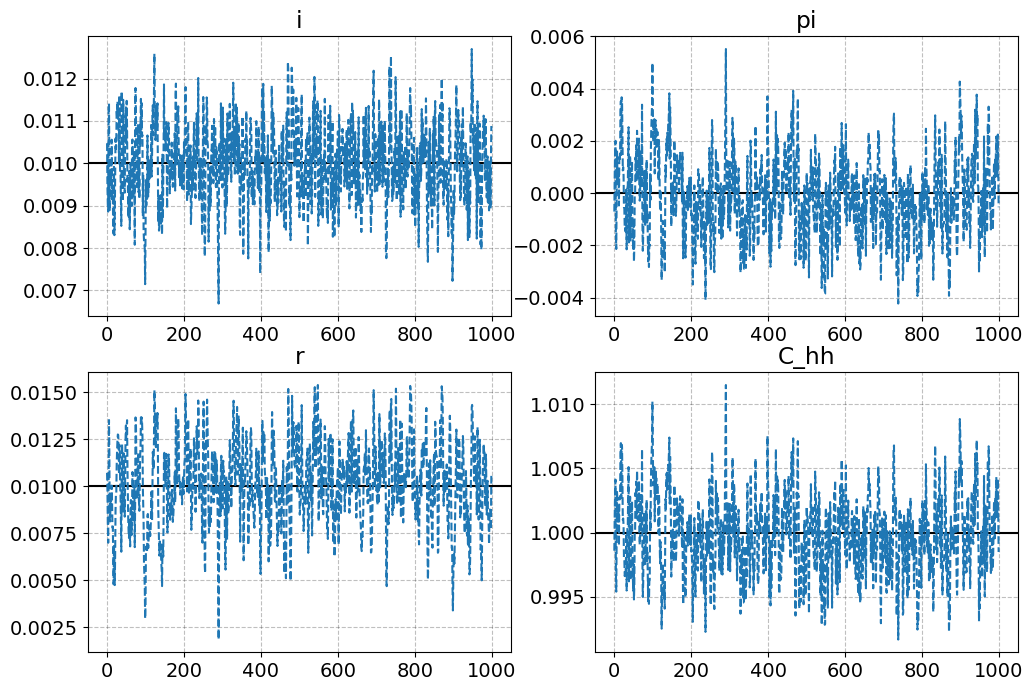

In [20]:
model_sim()

## 7. <a id='toc7_'></a>[Decomposing household behavior](#toc0_)

['w']
household problem solved along transition path in 1.1 secs
household problem simulated along transition in 0.4 secs

['r']
household problem solved along transition path in 1.1 secs
household problem simulated along transition in 0.3 secs

['d']
household problem solved along transition path in 1.0 secs
household problem simulated along transition in 0.3 secs

['tau']
household problem solved along transition path in 1.0 secs
household problem simulated along transition in 0.3 secs



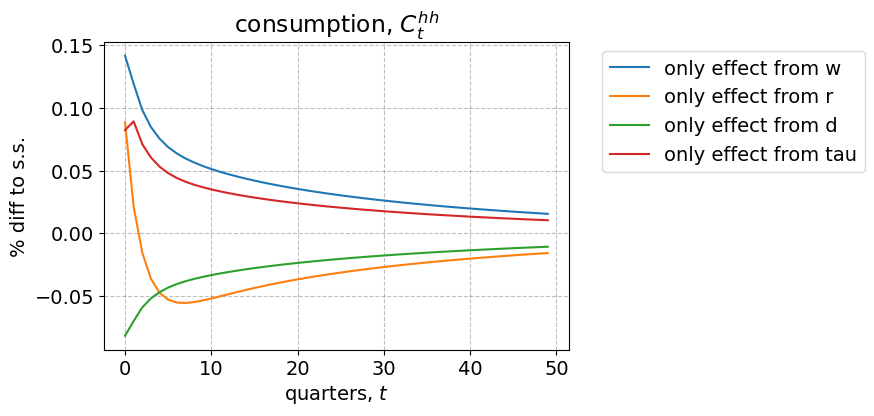

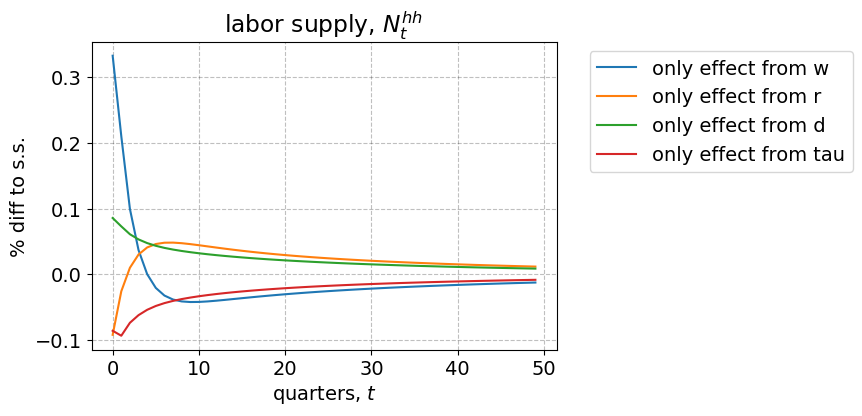

In [21]:
T_max = 50

fig_C = plt.figure(figsize=(6,4),dpi=100)
ax_C = fig_C.add_subplot(1,1,1)
ax_C.set_title('consumption, $C_t^{hh}$')
               
fig_N = plt.figure(figsize=(6,4),dpi=100)
ax_N = fig_N.add_subplot(1,1,1)
ax_N.set_title('labor supply, $N_t^{hh}$')
               
i_color = 0
for use_inputs in [[x] for x in model.inputs_hh]:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax_C.plot((path_alt.C_hh[:T_max]/ss.C_hh-1)*100,ls=ls,color=color,label=label);
    ax_N.plot((path_alt.N_hh[:T_max]/ss.N_hh-1)*100,ls=ls,color=color,label=label);    

for ax in [ax_C,ax_N]:
    ax.set_ylabel('% diff to s.s.')
    ax.set_xlabel('quarters, $t$')
    lgd = ax.legend(frameon=True,ncol=1,bbox_to_anchor=(1.05,1), loc='upper left',)

plt.show()

## 8. <a id='toc8_'></a>[Representative agent model (RANK)](#toc0_)

In [22]:
from HANKModel import RANKModelClass

In [23]:
model_RA = RANKModelClass(name='RA')
model_RA.find_ss()
model_RA.test_path()

shocks: Gamma istar G 
unknowns: Y w pi 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  N                0.0e+00
  s                0.0e+00
 blocks.taylor
  i                0.0e+00
 blocks.fisher
  r                8.7e-18
 blocks.government
  B                0.0e+00
  tau              4.9e-17
 blocks.intermediary_goods
  NKPC_res         0.0e+00 [target]
  adjcost          0.0e+00
  d                0.0e+00
 hh
  A_hh             2.3e-09
  C_hh             5.2e-11
  ELL_hh           5.1e-11
  N_hh             4.2e-11
 blocks.market_clearing
  A                0.0e+00
  clearing_N       1.3e-10 [target]
  clearing_A       1.3e-10 [target]
  clearing_Y       6.4e-11


In [24]:
model_RA.compute_jacs(do_print=False)

In [25]:
model_RA.find_transition_path(shocks=['istar'],do_print=False)

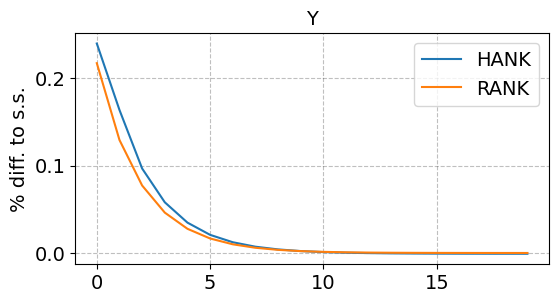

In [26]:
model.compare_IRFs([model,model_RA],['HANK','RANK'],['Y'],do_shocks=False,do_targets=False,ncols=2,T_max=20)

Check IBC in steady state:

In [27]:
assert np.isclose(ss.r*ss.A_hh+ss.w*ss.N+ss.d-ss.tau,ss.C_hh) # flow budget
assert np.isclose(ss.C_hh,ss.Y-ss.G-ss.adjcost) # resource constraint

# IBC
q = np.ones((par.T,1))
for t in range(1,par.T): q[t] = q[t-1]*1/(1+ss.r)

C_NPV = np.sum(q*ss.C_hh)
Y_RA_NPV = (1+ss.r)*ss.A_hh + np.sum(q*(ss.w*ss.N+ss.d-ss.tau))

assert np.isclose(C_NPV,Y_RA_NPV)

Make decomposition of consumption:

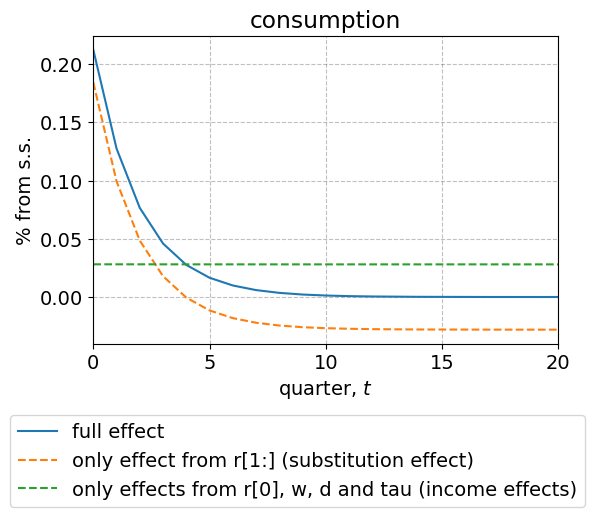

In [28]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title('consumption')

# a. full effect
C_RA = model_RA.path.Y-model_RA.path.G-model_RA.path.adjcost
ax.plot((C_RA/ss.C_hh-1)*100,label='full effect')

# bI. relative path
C_RA_r = np.zeros_like(C_RA)
for k in range(par.T): # backwards
    t = par.T-1-k
    C_RA_plus = C_RA_r[t+1] if t+1 < par.T else ss.C_hh
    r_plus = model_RA.path.r[t+1] if t+1 < par.T else ss.r
    C_RA_r[t] = (par.beta_RA*(1+r_plus))**(-1/par.sigma)*C_RA_plus # Euler

# bII. scale to satisfy IBC
q = np.ones((par.T,1))
for t in range(1,par.T): q[t] = q[t-1]*1/(1+model_RA.path.r[t])

C_RA_r_NPV = np.sum(q*C_RA_r)
Y_RA_NPV = (1+model_RA.ss.r)*ss.A_hh + np.sum(q*(ss.w*ss.N+ss.d-ss.tau))
fac = Y_RA_NPV/C_RA_r_NPV
C_RA_r *= fac

# bIII. plot only effect from r[1:]
ax.plot((C_RA_r/ss.C_hh-1)*100,ls='--',label='only effect from r[1:] (substitution effect)')
ax.set_xlim([0,20])

# c. other effects
ax.plot((C_RA-C_RA_r)/ss.C_hh*100,ls='--',label='only effects from r[0], w, d and tau (income effects)')
ax.set_xlim([0,20])

ax.set_xlabel('quarter, $t$')
ax.set_ylabel('% from s.s.')
ax.legend(frameon=True,ncol=1,bbox_to_anchor=(-0.2,-0.2), loc='upper left');

### 8.1. <a id='toc8_1_'></a>[Fiscal spending shock](#toc0_)

In [29]:
model_G = model.copy()
model_G.find_transition_path(shocks=['G'],do_print=False)

In [30]:
model_RA_G = model_RA.copy()
model_RA_G.find_transition_path(shocks=['G'],do_print=False)

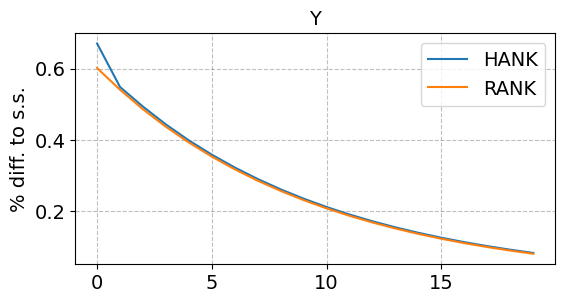

In [31]:
model_G.compare_IRFs([model_G,model_RA_G],['HANK','RANK'],['Y'],do_shocks=False,do_targets=False,ncols=2,T_max=20)

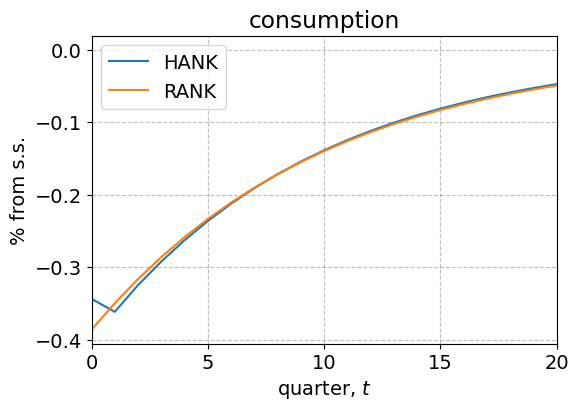

In [32]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.set_title('consumption')

ax.plot((model_G.path.C_hh/ss.C_hh-1)*100,label='HANK')

C_RA = model_RA_G.path.Y-model_RA_G.path.G--model_RA_G.path.adjcost
ax.plot((C_RA/ss.C_hh-1)*100,label='RANK')

ax.set_xlim([0,20])
ax.set_xlabel('quarter, $t$')
ax.set_ylabel('% from s.s.')
ax.legend(frameon=True);

**Note:** This close equivalence hinges on the government budget being balanced in each period.

## 9. <a id='toc9_'></a>[Extra: Allow for borrowing](#toc0_)

baseline
ss.A_hh = 5.60
np.sum(ss.c**(1-par.sigma)/(1-par.sigma)*ss.D) = -1.1310

borrowing allowed
ss.A_hh = 4.70
np.sum(ss.c**(1-par.sigma)/(1-par.sigma)*ss.D) = -1.1380



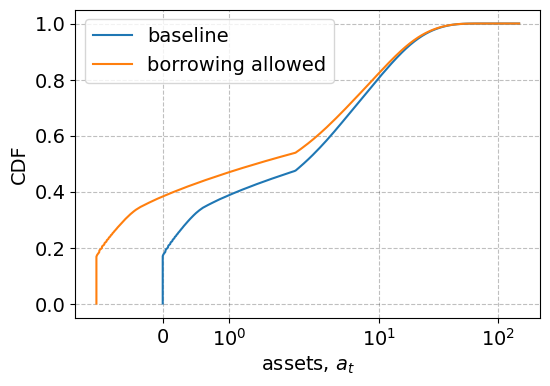

In [33]:
model_ = model.copy(name='borrowing allowed')
model_.par.a_min = -1.0
model_.solve_hh_ss()
model_.simulate_hh_ss()

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

for m in [model,model_]:

    print(m.name)
    par = m.par
    ss = m.ss
    
    print(f'{ss.A_hh = :.2f}')
    print(f'{np.sum(ss.c**(1-par.sigma)/(1-par.sigma)*ss.D) = :.4f}')

    y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1],label=m.name)
    print('')
        
ax.legend()
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')